In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import qutip

matplotlib.rcParams.update({'figure.figsize': (6, 2.5), 'font.size': 14})

# Simulating quantum dynamics

- Solving the Schrödinger/Master equation using QuTiP
    - Time evolution problem as a system of differential equations.
- How to describe a time-dependent Hamiltonian?
    - Simplify your model!
    - Code it in a more efficient way.
        - Full Hamiltonian as a Python function.
        - Time-dependent time coefficient `[c_j(t), H_j]`.
- Tasks: Simulating imperfect gate operation.
    - A Transmon qubit modelled as a three-level system.


## Dynamics of a quantum system

### Schrödinger equation:

$i\frac{d}{dt}|ψ⟩= \hat{H}|ψ⟩$

An Ordinary Differential Equation (ODE) of $|ψ⟩$.

- $|ψ⟩$ a complex vector
- $\hat{H}$ a square (hermitian) matrix

### Simulating the Hamiltonian dynamics using QuTiP
This is the solution to Task 1d:
<a id='solution_task1'></a>

In [2]:
from qutip import tensor, destroy, create, qeye, sigmaz, sigmax, sigmay, basis, sigmam, sigmap
num_level = 15 # resonator truncation level
wc = 1.0 # cavity frequency
wa = -1.0 # qubit/atom frenqency
g = 0.1  # coupling strength
# cavity mode operator
a = tensor(destroy(num_level), qeye(2))
# qubit/atom operators
sz = tensor(qeye(num_level), sigmaz())   # sigma-z operator
sm = tensor(qeye(num_level), destroy(2)) # sigma-minus operator
# the Jaynes-Cumming Hamiltonian
H = wc * a.dag() * a + wa/2 * sz + g * (a.dag() + a) * (sm + sm.dag())

In [3]:
psi0 = basis([num_level, 2], [0, 1])
tlist = np.linspace(0, 100, 1000)
## Call the QuTIP solver!
result = qutip.sesolve(H, psi0, tlist, e_ops=[a.dag() * a, sm.dag() * sm])

`sesolve` stands for the Schrödinger equation solver.

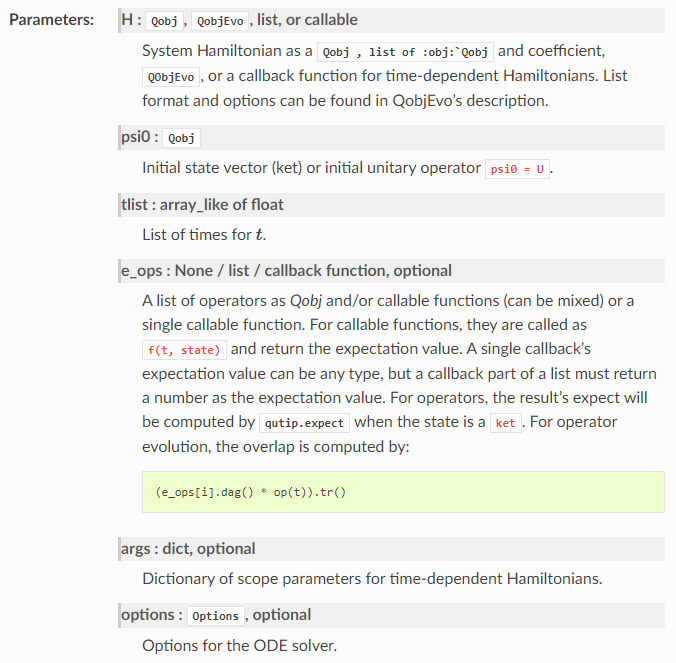

### How do you solve differential equations numerically?

Euler method: https://en.wikipedia.org/wiki/Euler_method

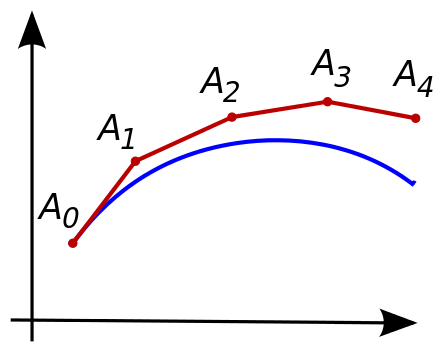



Runge–Kutta methods: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

$y_{n+1} = y_n + (k_1+2k_2+2k_3+k_4)h/6$

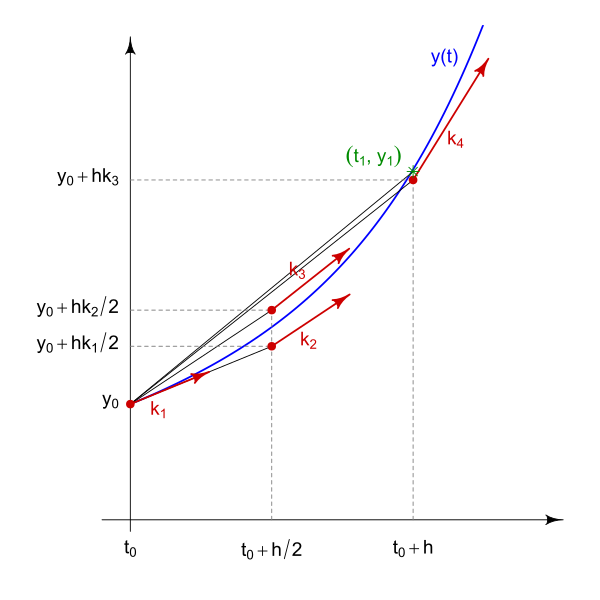

More advanced techniques used in SciPy:
- Adaptive step size
- Use sparse matrices to save memory
- ...

Which eventually gives you this!

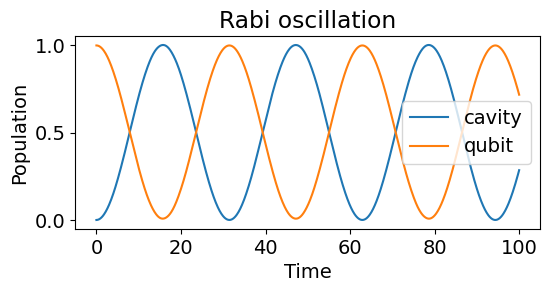

In [4]:
fig, ax = plt.subplots()
ax.plot(tlist, result.expect[0], label="cavity")
ax.plot(tlist, result.expect[1], label="qubit")
ax.set_xlabel("Time")  
ax.set_ylabel("Population")
ax.set_title("Rabi oscillation")
ax.legend();

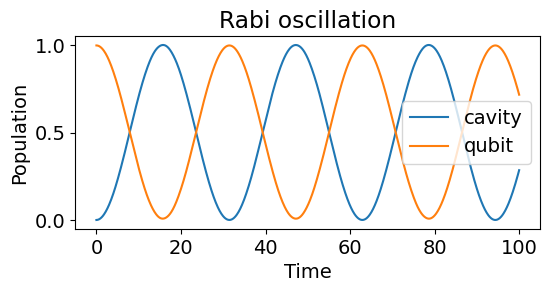

In [5]:
fig

### Open quantum system dynamics: target system + bath

Related to: Relaxation, Dephasing, Depolarising

#### Lindblad master equation:

$\frac{\partial \hat{\rho}(t)}{\partial t} = - i \left[\hat{H}(t), \hat{\rho}(t)\right] + \sum_{j=0}^{N-1}\gamma_n \mathcal{D}[\hat{L}_n] \hat{\rho}(t)$

- $\hat{H}$: the system Hamiltonian
- $\gamma_j$: the relaxation rate
- $\mathcal{D}[L_n]X=L_n X L_n^\dagger-\frac{1}{2} L_n^\dagger L_n X-\frac{1}{2}X L_n^\dagger L_n$ is the Lindblad dissipator
    - $L_j$: collapse operator

Define a collapse operator:

In [6]:
collapse_op = 0.1 * tensor([destroy(num_level), qeye(2)])
collapse_op

Quantum object: dims = [[15, 2], [15, 2]], shape = (30, 30), type = oper, isherm = False
Qobj data =
[[0.         0.         0.1        0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.1        0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.14142136 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.    

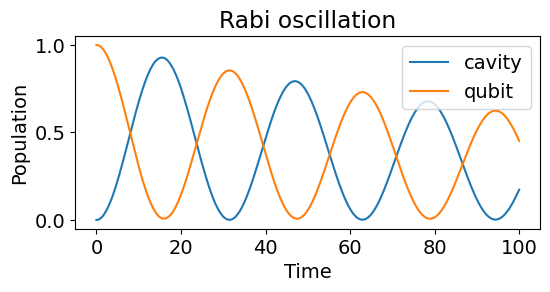

In [7]:
c_ops = [collapse_op]
## Call the Master equation solver!
result = qutip.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=[a.dag() * a, sm.dag() * sm])
plt.plot(tlist, result.expect[0], label="cavity")
plt.plot(tlist, result.expect[1], label="qubit")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Rabi oscillation")
plt.legend()
plt.show()

## How to describe a time-dependent Hamiltonian?
- For time-independent problems, diagonalizing the Hamiltonian could be faster as long as the Hamiltonian is not too big.
- But what about a time-dependent problem?

In [8]:
from scipy import signal
def get_pulse(pulse):
    return np.concatenate([np.zeros(20), pulse, np.zeros(20)])

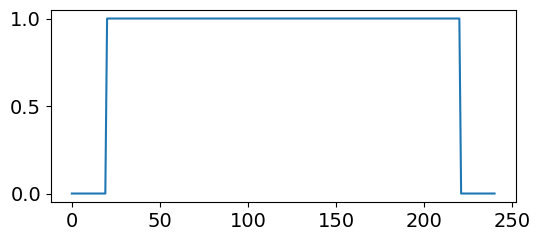

In [9]:
plt.plot(get_pulse(signal.windows.boxcar(201)));

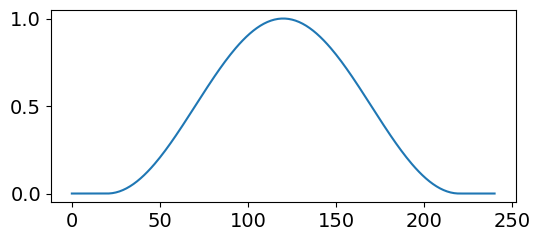

In [10]:
plt.plot(get_pulse(signal.windows.hann(201)));

### The simplest way, H as a Python function

Example: Single-qubit drive $ H = \omega \frac{\sigma_z}{2}+\Omega(t) \cos(\omega t) \frac{\sigma_x}{2}$

A time-dependent pulse shape $\Omega(t)$

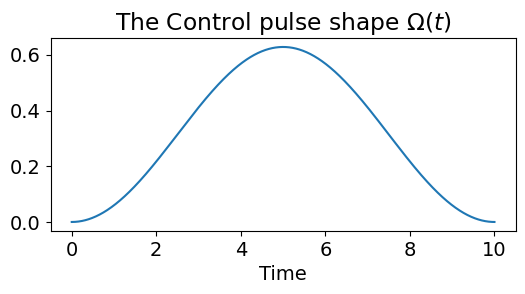

In [11]:
T = 10
args={"w": 2*np.pi*1, "Omega_0": 2*np.pi/T, "T":T}
def Omega(t, args):
    return args["Omega_0"] * np.sin(np.pi*t/args["T"])**2

tlist = np.linspace(0, T, 1000)
plt.plot(tlist, Omega(tlist, args))
plt.title("The Control pulse shape $\Omega(t)$")
plt.xlabel("Time");

Define a Python function that
- excute the simulation
- print the execution time
- plot the population time

In [12]:
def run_simulation(H, tlist, args, zoom_in=False):
    import time
    start = time.time()
    # The simulation itself.
    result = qutip.sesolve(
        H, basis(2, 0), tlist=tlist, args=args, e_ops=[create(2) * create(2).dag()],
        options=qutip.Options(store_states=True))
    end = time.time()
    # Print the execution time.
    print("Elapsed time:", end - start)
    
    # Plot the population.
    plt.plot(tlist, result.expect[0])
    plt.xlabel("Time")
    plt.ylabel("Population of $|1>$")
    plt.show()
    return result

A Python function that implements $ H = \omega \frac{\sigma_z}{2}+\Omega(t) \cos(\omega t) \frac{\sigma_x}{2}$

Elapsed time: 26.036144733428955


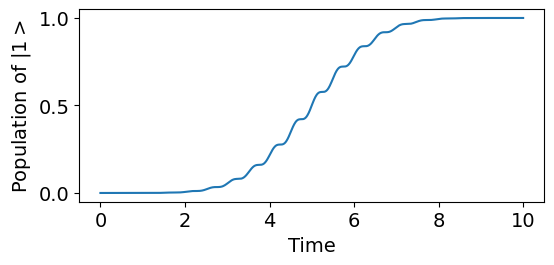

In [13]:
T = 10
args={"w": 2*np.pi*1, "Omega_0": 2*np.pi/T, "T":T}

def H(t, args):
    H0 = args["w"] * sigmaz() / 2
    Hd = Omega(t, args) * np.cos(args["w"] * t) * sigmax()
    return H0 + Hd

tlist = np.linspace(0, T, 1000)
result = run_simulation(H, tlist, args)

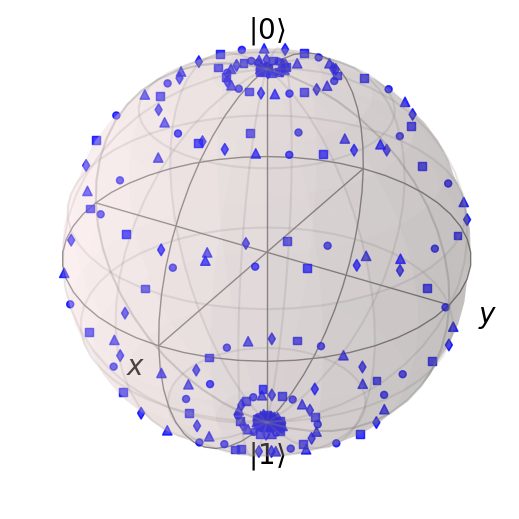

In [14]:
bloch = qutip.Bloch()
bloch.point_color = ["b"]
bloch.point_markerlist = ["o"]
bloch.vector_color = ["b"] * len(result.states)
bloch.add_states(result.states[::4], alpha=0.5, kind= 'point')
bloch.show()

#### The model matters: Applying the Rotating Wave Approximation (RWA)
Define $U=e^{i \omega\sigma_z}$ and $H'=UHU^{\dagger}+iUU^{\dagger}$. Because $\Omega \ll \omega$:
$
H' = 
\frac{\Omega}{2}
\left(
\sigma_x
+
\sigma_{-}e^{2i\omega t}+ \sigma_{+}e^{-2i\omega t}
\right)
\approx
\frac{\Omega(t)}{2}
\sigma_x
$

<!-- 
$
H_{\rm{RWA}} = 
\omega \frac{\sigma_z}{2}
+
\Omega \frac{1}{2}
\left(
\sigma_{-} e^{i \omega t} + \sigma_{+} e^{-i \omega t}
\right)
$ -->

Elapsed time: 7.716481924057007


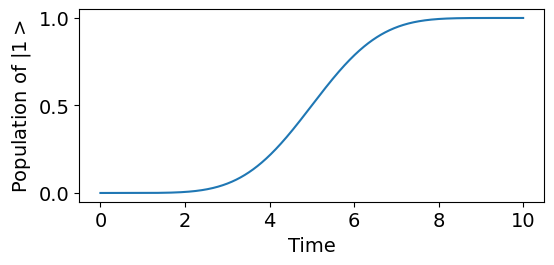

In [15]:
def Omega(t, args):
    return args["Omega_0"] * np.sin(np.pi*t/args["T"])**2
def H(t, args):
    return Omega(t, args) * sigmax() / 2
tlist = np.linspace(0, T, 1000)
result = run_simulation(H, tlist, args)

**3 times faster!**

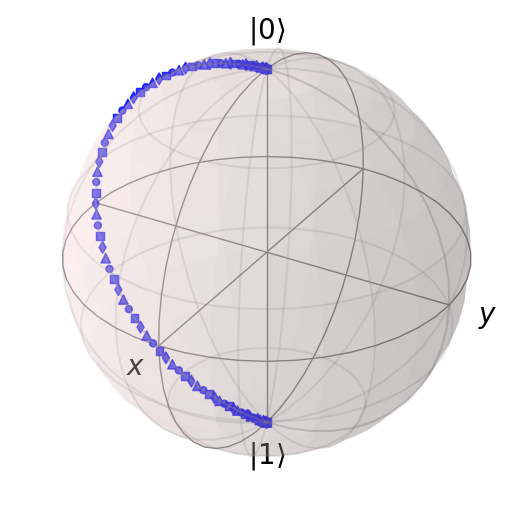

In [16]:
bloch = qutip.Bloch()
bloch.point_color = ["b"]
bloch.point_markerlist = ["o"]
bloch.vector_color = ["b"] * len(result.states)
bloch.add_states(result.states[::10], alpha=0.5, kind= 'point')
bloch.show()

### A better way to code your Hamiltonian

- Previous: Arbitrary time-dependent Hamiltonian defined as a Python function
- Now: Time-dependent coefficients and constant Hamiltonian
    $H = H_0 + c_1(t) H_1 + c_2(t) H_2 + \cdots$

#### Syntax in QuTiP
- ``H = [H_0, [Hc_1, c_1(t)], [Hc_2, c_2(t)]...]``

#### Why does it make a difference?
- At each step:
    - Previous: Evaluate ``H(t, args)`` which returns a N times N matrix.
    - Now: Evaluate a few ``c_j(t)``, each returns a number. ``Hc_j`` is constant.
- Moreover
    - Python is **slow**, compared to more low-level programming language like C. We store ``Hc_j`` as C object (using Cython).



#### Function-based coefficients

``[H0, [Hc1, c1(t, args)], [Hc2, c2(t, args)]...]``

Elapsed time: 0.26033997535705566


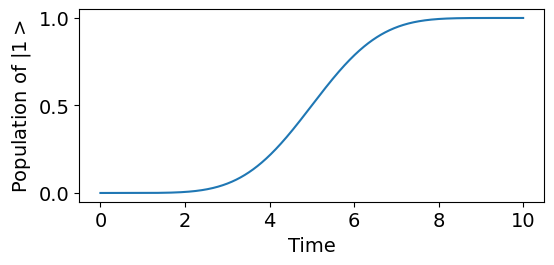

function

In [17]:
def Omega(t, args):
    return args["Omega_0"] * np.sin(np.pi*t/args["T"])**2
Hc = sigmax() / 2
# Omega is a Python function
H = [[Hc, Omega]]
tlist = np.linspace(0, T, 1000)
result = run_simulation(H, tlist, args)
type(Omega)

**50 times faster!**

#### Array-based coefficients

``[H0, [Hc1, np.array], [Hc2, np.array]...]``

**Caveat**: Interpolation is used. Sampling error.

Elapsed time: 0.16177678108215332


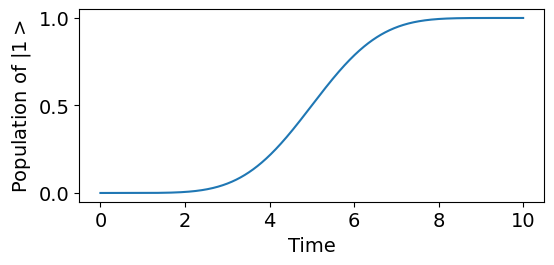

numpy.ndarray

In [18]:
Hc = sigmax() / 2
# Define Omega as an array
Omega = args["Omega_0"] * np.sin(np.pi*tlist /args["T"])**2
H = [Hc, Omega]
result = run_simulation(H, tlist, args)
type(Omega)

It is very fast even for the dynamics without RWA!

(The difference w/o RWA is not that big here because the system is small.)

Elapsed time: 0.15414667129516602


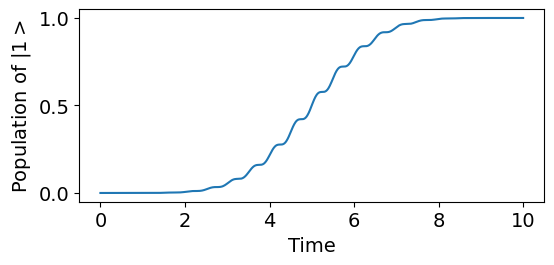

In [19]:
T = 10
args={"w": 2*np.pi*1, "Omega_0": 2*np.pi/T, "T":T}
H0 = args["w"] * sigmaz() / 2
Hc = sigmax()
Omega = args["Omega_0"] * np.sin(np.pi*tlist /args["T"])**2
# Use H0 and cos(w*t)
H = [H0, [Hc, Omega * np.cos(args["w"] * tlist)]]
result = run_simulation(H, tlist, args)

## Example: Control of a Transmon qubit

### Transmon qubit - weakly anharmonic oscillator
$
H_0 = w_0 a^{\dagger}a + \frac{\alpha}{2}a^{\dagger}a^{\dagger}aa
$

$
H_c = \Omega_z a^{\dagger}a + \Omega_x(a+a^{\dagger}) + \Omega_y i( a^{\dagger}-a)
$

In [21]:
# Define the operators
a = destroy(3)
alpha = -2 * np.pi * 0.3  # GHz
# Hamiltonian in the rotating frame
H0 = alpha/2 * a.dag() * a.dag() * a * a
Hx = a + a.dag()
Hy = - 1.j * a + 1.j * a.dag()
Hz = a.dag() * a

In [22]:
H0 + 2 * np.pi * 0.05 * Hx

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.31415927  0.        ]
 [ 0.31415927  0.          0.44428829]
 [ 0.          0.44428829 -1.88495559]]

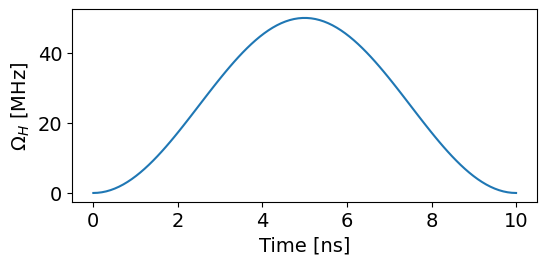

In [23]:
# Define a Hann pulse shape
T = 10 # ns
tlist = np.linspace(0, T, 100)
Omega_0 = 2 * np.pi * 1 / T  # GHz
hann_window = np.sin(np.pi*tlist/T)**2
pulse = Omega_0 / 2 * hann_window

plt.plot(tlist, pulse / 2 / np.pi * 1000)
plt.xlabel("Time [ns]")
plt.ylabel("$\Omega_H$ [MHz]");

### Implementing an X gate using the Hann pulse

In [24]:
H_hann = [H0, [Hx, pulse]]
# propagator computes the full unitary
U = qutip.propagator(H_hann, t=tlist)[-1]
print("Leakage transition probability 0-2:", np.abs(U[0,2])**2)
print("Leakage transition probability 1-2:", np.abs(U[1,2])**2)
print("X gate fidelity:", qutip.average_gate_fidelity(qutip.Qobj(U.full()[:2,:2]), sigmax()))

Leakage transition probability 0-2: 0.00034875894614593814
Leakage transition probability 1-2: 0.0004032776431704622
X gate fidelity: 0.9860719772288


### DRAG (Derivative Removal by Adiabatic Gate) pulse
- $\Omega_x = \Omega - \frac{\Omega^3}{\alpha^2}$
- $\Omega_y = - \frac{\dot{\Omega}}{\alpha}$
- $\Omega_z = -  \frac{2\Omega^2}{\alpha}$

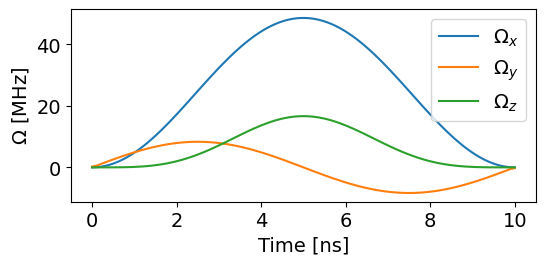

In [25]:
deriv_pulse = np.gradient(pulse, tlist[1] - tlist[0]) # Compute the derivative
x_pulse = pulse - (pulse**3 / (alpha**2))
y_pulse = - deriv_pulse / alpha
z_pulse = - 2 * (pulse**2) / alpha

fig, ax = plt.subplots()
ax.plot(tlist, x_pulse / 2 / np.pi * 1000, label="$\Omega_x$")
ax.plot(tlist, y_pulse / 2 / np.pi * 1000, label="$\Omega_y$")
ax.plot(tlist, z_pulse / 2 / np.pi * 1000, label="$\Omega_z$")
ax.legend()
ax.set_xlabel("Time [ns]")
ax.set_ylabel("$\Omega$ [MHz]");

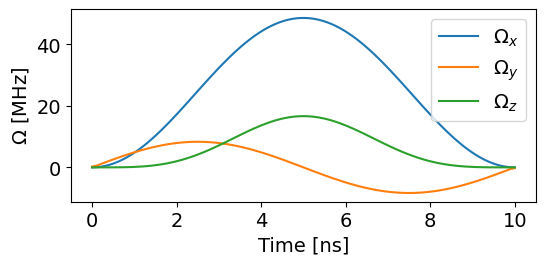

In [26]:
deriv_pulse = np.gradient(pulse, tlist[1] - tlist[0]) # Compute the derivative
x_pulse = pulse - (pulse**3 / (alpha**2))
y_pulse = - deriv_pulse / alpha
z_pulse = - 2 * (pulse**2) / alpha
fig

In [27]:
# Apply the DRAG pulse
H_drag = [H0, [Hx, x_pulse], [Hy, y_pulse], [Hz, z_pulse]]
U = qutip.propagator(H_drag, t=tlist)[-1]
print("Leakage transition probability 0-2:", np.abs(U[0,2])**2)
print("Leakage transition probability 1-2:", np.abs(U[1,2])**2)
print("X gate fidelity:", qutip.average_gate_fidelity(qutip.Qobj(U.full()[:2,:2]), sigmax()))

Leakage transition probability 0-2: 8.869000091987183e-06
Leakage transition probability 1-2: 8.9178772454437e-06
X gate fidelity: 0.9999873448401552


**Task 2.1**: The leakage can also be reduced by increasing the gate time and rescaling the pulse amplitude so that the total area is still 𝜋. How long does the gate time need to be so that the Hamiltonian with Hann pulse achieves the same fidelity as the Hamiltonian with DRAG?
Tips: Repeat the simulation for different gate times and plot the infidelity as a function of time on log scale.

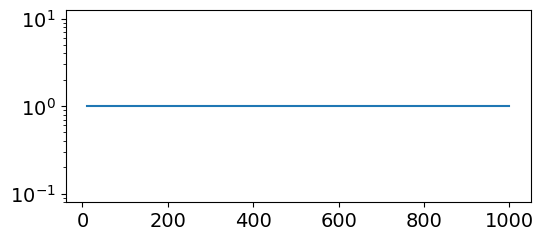

In [28]:
gate_time_list = np.linspace(10, 1000, 100)
infidelity_list = []
for T in gate_time_list:
    # Compute the fidelity here.
    fidelity = 0.
    infidelity_list.append(1 - fidelity)
plt.plot(gate_time_list, infidelity_list)
plt.yscale("log")

**Task 2.2**: Plot the population of the second level (the non-computational level) during the gate execution. What do you see for the Hamiltonian with and without DRAG correction?

Tips: Use `sesolve` and the optional parameter `e_ops` to directly obtain the expectation values. Have a look again at [the solution of Task 1](#solution_task1).